In [1]:
import pickle
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
import random
import copy
import math
from scipy.optimize import linprog
import time
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
# mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')
import networkx as nx


# 1. Load input

In [2]:
lines = 500000
random.seed(10)
dataset = 'russian'

Load episode set $E$ with the users that retweeted each original tweet in the trace. 

Each episode $E_{s}$ includes the users that retweeted s, ordered chronologically, as they appear in the trace. The first user in each episode is the user that originally tweeted the tweet, and is denoted by $r_{s}$. Subsequent users in $E_{s}$ are users that retweeted s, either directly from user $r_{s}$ or from another user that appears in Es before them.

In [3]:
D = pickle.load(open("./Extracted/"+dataset+"/D"+ str(lines) + ".p", "rb"))

In [4]:
E = pickle.load(open("./Extracted/"+dataset+"/E"+ str(lines) + ".p", "rb"))

In [5]:
for tweet in E:
    E[tweet] = list(dict.fromkeys(E[tweet]))

Load the set of original tweets denoted by $S$. 

The set of original tweets is denoted by $S$, where $S$ = S is the total number of original tweets

In [6]:
S = pickle.load(open("./Extracted/"+dataset+"/S"+ str(lines) + ".p", "rb"))

Load $U$ set xith unique users

In [8]:
# U = pickle.load(open("./Extracted/U"+ str(lines) + ".p", "rb"))
# U = list(U)

Load $M_{ij}$ variables that count number of episodes where the ordered pair (i,j) appears

In [9]:
M = pickle.load(open("./Extracted/"+dataset+"/M_d"+ str(lines) + ".p", "rb"))

Load $Q_{ij}$ results for the ordered pair (i,j) derived from the consrained algorithm

In [11]:
Q = pickle.load(open("./Extracted/"+dataset+"/results/Q_constrained_"+ str(lines) + ".p", "rb"))

Load $s_{ij}$ derived from the consrained algorithm

In [12]:
s = pickle.load(open("./Extracted/"+dataset+"/results/s_constrained_"+ str(lines) + ".p", "rb"))

Load $k_{ij}$ derived from Saito

In [14]:
# k = pickle.load(open("./Extracted/"+dataset+"/results/k_saito_"+ str(lines) + ".p", "rb"))

Load $Q_{ij}$ derived from Newman's

In [15]:
# Q_newman = pickle.load(open("./Extracted/"+dataset+"/Q_newman_"+ str(lines) + ".p", "rb"))

## Necessary functions

In [13]:
def flatten(obj):
    if type(obj) == list:
        return [l for L in obj for l in L]
    if type(obj) == dict:
        return [l for i in obj for l in obj[i].values()]
    if type(obj) == defaultdict:
        return [l for i in obj for l in obj[i].values()]

In [14]:
def create_serpent_graph(U,D):
    G = nx.DiGraph()
    G.add_nodes_from(U)
    for tweet in D:
        for time in D[tweet]:
            ind = list(D[tweet].keys()).index(time)
            if ind+1==len(D[tweet]): break
            next_time = list(D[tweet].keys())[ind+1]
            for u1 in D[tweet][time]:
                for u2 in D[tweet][next_time]:
                    G.add_edge(u1,u2)
    return G

In [15]:
def create_saito_graph(U,k):
    G = nx.DiGraph()
    G.add_nodes_from(U)

    for i in k:
        for j in k[i]:
            if k[i][j] > 0.5:
                G.add_edge(i,j)
    return G

In [30]:
def create_star_graph(U,E):
    G = nx.DiGraph()
    G.add_nodes_from(U)
    for s in E:
        for j in E[s][1:]:
            G.add_edge(E[s][0],j)
    return G

In [17]:
def create_our_graph(U,Q):
    G = nx.DiGraph()
    G.add_nodes_from(U)
    for i in Q:
        for j in Q[i]:
            if Q[i][j] > 0.5:
                G.add_edge(i,j)
    return G

In [18]:
def create_newman_graph(U,Q):
    G = nx.DiGraph()
    G.add_nodes_from(U)

    for i in Q:
        for j in Q[i]:
            if Q[i][j] > 0.5:
                G.add_edge(i,j)
    return G

In [19]:
def wedge_metric(graph):
    numerator = 0
    denominator = 0

    for i in graph.nodes:
        leaders = set(graph.predecessors(i))
        followers = set(graph.successors(i))
        friends = leaders.intersection(followers)
        if len(leaders) + len(followers) < 2:
            continue
        if leaders==followers and len(leaders)==1:
            continue
        L = len(leaders)
        F = len(followers)
        LintF = len(friends)
        numerator += L*F - LintF
        denominator += (L+F)**2 - L - F - 2*LintF

    if denominator != 0:
        result = 2 * numerator / denominator
    else:
        result = 0
        
    return result

In [20]:
def f_check(E, Q):
    '''
    Function that checks feasibility of results

    '''
    retweets = 0 # minimum existing edges
    infeasible_episodes = 0 
    total_feasible_edges = []
    total_inf = 0 
    for s in E:
        feasible_edges = 0 
        for j in E[s]:
            indx = E[s].index(j)
            if indx!=0:
                u_before = E[s][:indx]
                for i in u_before: 
                    if i in Q and j in Q[i] and Q[i][j] > 0.5:
                        feasible_edges +=1
                        total_feasible_edges.append((i,j))

        infeasible = (len(E[s]) - 1) - feasible_edges
        if infeasible > 0:
#             print('Tweet', s, 'retweeted by', len(E[s])-1, 'users in total. But, we only found:', feasible_edges, 'feasible edges, so the infeasible ones are:', infeasible)            
            total_inf+=infeasible
            infeasible_episodes+=1
            
        retweets += len(E[s])-1
        total_feasible_edges = list(set(total_feasible_edges))
        
    return infeasible_episodes
        
#     print('Total feasbile edges:', len(total_feasible_edges), 'Number of retweets', retweets)
#     print('Total infeasible edges:', total_inf)

In [21]:
def longest_path(E, U, Q, k, graph_type):
    max_l = 0
    max_path = 0
    
    if graph_type=='ours' or graph_type=='newman':    
        for s in E:
            G = nx.DiGraph()
            G.add_nodes_from(U)
            for j in E[s][1:]:
                    indx = E[s].index(j)
                    u_before = E[s][:indx]
                    for i in u_before: 
                            if j in Q[i] and Q[i][j] > 0.5:
                                G.add_edge(i,j)

            if len(nx.dag_longest_path(G))>max_l: 
                max_l = len(nx.dag_longest_path(G))
                max_path = nx.dag_longest_path(G)
                
    if graph_type=='star':
        for s in E:
            G = nx.DiGraph()
            G.add_nodes_from(U)
            for j in E[s][1:]:
                G.add_edge(E[s][0],j)

            if len(nx.dag_longest_path(G))>max_l: 
                max_l = len(nx.dag_longest_path(G))
                max_path = nx.dag_longest_path(G)
                
    if graph_type=='saito':    
        for s in E:
            G = nx.DiGraph()
            G.add_nodes_from(U)
            for j in E[s][1:]:
                    indx = E[s].index(j)
                    u_before = E[s][:indx]
                    for i in u_before: 
                            if j in k[i] and k[i][j] > 0.5:
                                G.add_edge(i,j)

            if len(nx.dag_longest_path(G))>max_l: 
                max_l = len(nx.dag_longest_path(G))
                max_path = nx.dag_longest_path(G)
                
    return max_l, max_path   


In [22]:
def plot_tweetgraph(s, E, S, Q, k, pos, graph_type):
        
        G = nx.DiGraph()
        
        if graph_type=='ours' or graph_type=='newman':
            t = 0
            for j in E[s][1:]:
                G.add_node(j)
                indx = E[s].index(j)
                u_before = E[s][:indx]
                for i in u_before: 
                        G.add_node(i)
                        if j in Q[i] and Q[i][j] > 0.5:
                            G.add_edge(i,j, label=f'{t}')
                            t+=1
                            
        elif graph_type=='star':
            
            G.add_node(E[s][0])
            for j in E[s][1:]:
                    G.add_edge(E[s][0],j)
                    G.add_node(j)
                    
        elif graph_type=='saito':
            t = 0
            for j in E[s][1:]:
                G.add_node(j)
                indx = E[s].index(j)
                u_before = E[s][:indx]
                for i in u_before: 
                        G.add_node(i)
                        if j in k[i] and k[i][j] > 0.5:
                            G.add_edge(i,j, label=f'{t}')
                            t+=1
                            
        elif graph_type=='serpent':
            for time in D[s]:
                ind = list(D[tweet].keys()).index(time)
                if ind+1==len(D[tweet]): break
                next_time = list(D[tweet].keys())[ind+1]
                for u1 in D[tweet][time]:
                    for u2 in D[tweet][next_time]:
                        G.add_edge(u1,u2)

        # print('- Edges:', G.edges)
        color_map = []
        cmap = plt.get_cmap('Greens')

        for node in G:
            if node == S[tweet]:
                color_map.append('green')
            else:
                color_map.append('yellow')
        
        pos = nx.spring_layout(G)        
        nx.draw_networkx_nodes(G, pos, node_color = color_map, cmap=plt.get_cmap('jet'), node_size = 300)
        nx.draw_networkx_edges(G, pos, edge_color='r', arrows=True)
        nx.draw_networkx_labels(G, pos, font_size=8)
        if graph_type=='ours' or graph_type=='saito':
            nx.draw_networkx_edge_labels(G, pos, font_size=8)
        plt.show()
    

# Statistics

## 1. number of infeasible episodes

In [23]:
print('-Total number of episodes:', len(E))
inf_ep = f_check(E, Q)
print('-Total infeasible episodes in our graph:', inf_ep)
inf_ep = f_check(E, k)
print('-Total infeasible episodes in Saitos graph:', inf_ep)
inf_ep = f_check(E, Q_newman)
print('-Total infeasible episodes in Newmans graph:', inf_ep)

df['']

-Total number of episodes: 111
-Total infeasible episodes in our graph: 0
-Total infeasible episodes in Saitos graph: 42
-Total infeasible episodes in Newmans graph: 111


In [53]:
data = dict()
data['Graph Type'] = ['Ours','Saito','Star','Serpent', 'Newman']

# df = pd.DataFrame(data, columns= ['Graph Type', 'Infeasible Episodes', 'Number of Edges'])
# df.to_csv (r'C:\Users\Ron\Desktop\export_dataframe.csv', index = False, header=True)

## 2. Expected number of edges

In [31]:
#Create graphs
G_star = create_star_graph(U,E)
G_ours = create_our_graph(U,Q)
G_saito = create_saito_graph(U,k)
G_newman = create_newman_graph(U,Q_newman)
G_serpent = create_serpent_graph(U,D)

In [55]:
edges_ours = len(G_ours.edges())
edges_saito = len(G_saito.edges())
edges_star = len(G_star.edges())
edges_serpent = len(G_serpent.edges())
edges_newman = len(G_newman.edges())

data['Number of edges'] = [edges_ours, edges_saito, edges_star, edges_serpent, edges_newman]

In [33]:
# #OURS

# exp_edges = sum(Q[i][j] for i in Q for j in Q[i])
# print('- Expected number of edges in our graph:', exp_edges, 'out of', len(U)*(len(U)-1), 'possible ones')

# #SAITO

# probs = np.histogram(flatten(k))[1]
# probs = probs[1:]
# nbs = np.histogram(flatten(k))[0]
# lena = len(probs)
# exp_edges = sum(probs[i]*nbs[i] for i in range(0,lena))
# print('- Expected number of edges in Saitos graph:', exp_edges, 'out of', len(U)*(len(U)-1), 'possible ones')

# #NEWMAN

# exp_edges = sum(Q_newman[i][j] for i in Q_newman for j in Q_newman[i])
# print('- Expected number of edges in Newmans graph:', exp_edges, 'out of', len(U)*(len(U)-1), 'possible ones')

In [34]:
# # plot k
# fig, ax = plt.subplots()
# ax.hist(flatten(k), facecolor='yellow', edgecolor='red')
# # ax.set_yscale('log')
# plt.xlabel("k_ij distribution")
# plt.ylabel("Number of edges")
# plt.show()
# plt.close()

In [35]:
# degree_sequence = list(G_ours.out_degree())

# # plot k
# fig, ax = plt.subplots()
# ax.hist(np.array(degree_sequence)[:,1], facecolor='yellow', edgecolor='red')
# # ax.set_yscale('log')
# plt.xlabel("k_ij distribution")
# plt.ylabel("Number of edges")
# plt.show()
# plt.close()
# plt.close()

## 3. Average out degree

In [57]:
av_ours = sum(d[1] for d in G_ours.out_degree())/float(len(G_ours))
av_saito = sum(d[1] for d in G_saito.out_degree())/float(len(G_saito))
av_star = sum(d[1] for d in G_star.out_degree())/float(len(G_star))
av_serpent = sum(d[1] for d in G_serpent.out_degree())/float(len(G_serpent))
av_newman = sum(d[1] for d in G_newman.out_degree())/float(len(G_newman))

data['Average out degree'] = [av_ours, av_saito, av_star, av_serpent, av_newman]

In [28]:
degree_sequence = list(G_ours.out_degree())
max_degree_our = max(np.array(degree_sequence)[:,1])
print("Maximum degree of Our graph: " + str(max_degree))

degree_sequence = list(G_saito.out_degree())
max_degree_saito = max(np.array(degree_sequence)[:,1])
print("Maximum degree of Saito graph: " + str(max_degree))


degree_sequence = list(G_star.out_degree())
max_degree_saito = max(np.array(degree_sequence)[:,1])
print("Maximum degree of Star graph : " + str(max_degree))

degree_sequence = list(G_serpent.out_degree())
max_degree_serpent = max(np.array(degree_sequence)[:,1])
print("Maximum degree of Serpent graph: " + str(max_degree))


degree_sequence = list(G_newman.out_degree())
max_degree_newmans = max(np.array(degree_sequence)[:,1])
print("Maximum degree of Newman's graph: " + str(max_degree))


Maximum degree of Our graph: 9
Maximum degree of Saito graph: 25
Maximum degree of Star graph : 71
Maximum degree of Serpent graph: 25
Maximum degree of Newman's graph: 9


In [29]:
degree_sequence = list(G_ours.in_degree())
max_degree = max(np.array(degree_sequence)[:,1])
print("Min degree of Our graph: " + str(max_degree))

degree_sequence = list(G_saito.in_degree())
max_degree = max(np.array(degree_sequence)[:,1])
print("Min degree of Saito graph: " + str(max_degree))

degree_sequence = list(G_star.in_degree())
max_degree = max(np.array(degree_sequence)[:,1])
print("Min degree of Star graph : " + str(max_degree))

degree_sequence = list(G_serpent.in_degree())
max_degree = max(np.array(degree_sequence)[:,1])
print("Min degree of Serpent graph: " + str(max_degree))

degree_sequence = list(G_newman.in_degree())
max_degree = max(np.array(degree_sequence)[:,1])
print("Min degree of Newman's graph: " + str(max_degree))


Min degree of Our graph: 9
Min degree of Saito graph: 11
Min degree of Star graph : 9
Min degree of Serpent graph: 25
Min degree of Newman's graph: 71


In [81]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

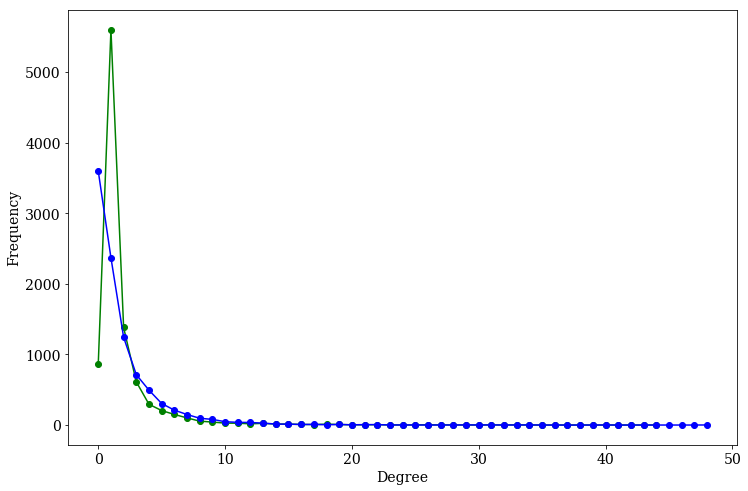

In [232]:
in_degree_freq = degree_histogram_directed(G_ours, in_degree=True)
out_degree_freq = degree_histogram_directed(G_ours, out_degree=True)
in_degrees = range(len(in_degree_freq))
out_degrees = range(len(out_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.plot(range(len(in_degree_freq)), in_degree_freq, 'go-', label='in-degree') 
plt.plot(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')

in_degree_freq = degree_histogram_directed(G_saito, in_degree=True)
out_degree_freq = degree_histogram_directed(G_saito, out_degree=True)
in_degrees = range(len(in_degree_freq))
out_degrees = range(len(out_degree_freq))

in_degree_freq = degree_histogram_directed(G_star, in_degree=True)
out_degree_freq = degree_histogram_directed(G_star, out_degree=True)
in_degrees = range(len(in_degree_freq))
out_degrees = range(len(out_degree_freq))

in_degree_freq = degree_histogram_directed(G_newman, in_degree=True)
out_degree_freq = degree_histogram_directed(G_newman, out_degree=True)
in_degrees = range(len(in_degree_freq))
out_degrees = range(len(out_degree_freq))


In [257]:
# def plot_degree_dist(G, graph_type):
#     degrees = [G.degree(n) for n in G.nodes()]
#     counts, bins, bars = plt.hist(degrees, density=True)
#     print(counts, bins)
#     print(sum(counts))
#     exp_edges = sum(counts[i]*bins[i] for i in range(0,len(counts)))
#     print('- Expected number of edges in Newmans graph:', exp_edges)
#     plt.hist(degrees, density=True)
#     plt.title('degree distribution plot (P(deg=k), k=0,1,…) for graph_type graph')
#     plt.show()

# plot_degree_dist(G_ours, 'Our')
# plot_degree_dist(G_saito, 'Saito')
# plot_degree_dist(G_star, 'Star')
# plot_degree_dist(G_newman, 'Newman')
# plot_degree_dist(G_serpent, 'Serpent')

## 5. Graph diameter

The maximum among all the distances between a vertex to all other vertices is considered as the diameter of the Graph G.

In [37]:
def diameter_scc(G, graph_type):
    print('- Diameter for strongly connected components of', graph_type)
    for C in nx.strongly_connected_components(G):
        C = G.subgraph(C)
        if len(C)>1: # skip one nodes
            print('Strongly connected component with diameter:', nx.diameter(C)) # maximum eccentricity

diameter_scc(G_ours, 'Ours')
diameter_scc(G_saito, 'Saito')
diameter_scc(G_star, 'Star')
diameter_scc(G_serpent, 'Serpent')
diameter_scc(G_newman, 'Newman')

- Diameter for strongly connected components of Ours
Strongly connected component with diameter: 1
- Diameter for strongly connected components of Saito
- Diameter for strongly connected components of Star
Strongly connected component with diameter: 1
- Diameter for strongly connected components of Serpent
Strongly connected component with diameter: 4
Strongly connected component with diameter: 44
Strongly connected component with diameter: 4
Strongly connected component with diameter: 1
- Diameter for strongly connected components of Newman
Strongly connected component with diameter: 1


## 6. Wedge metric

In [38]:
print('- Wedge metric for our graph:', wedge_metric(G_ours))
print('- Wedge metric for the star graph:', wedge_metric(G_star))
print('- Wedge metric for the Saito graph:', wedge_metric(G_saito))
print('- Wedge metric for the Serpent graph:', wedge_metric(G_serpent))
print('- Wedge metric for the Newman graph:', wedge_metric(G_newman))


- Wedge metric for our graph: 0.423692636072572
- Wedge metric for the star graph: 0.008169934640522876
- Wedge metric for the Saito graph: 0.3199285075960679
- Wedge metric for the Serpent graph: 0.31484671029968997
- Wedge metric for the Newman graph: 0.009416877942774357


## 7. Cumulative degree distribution plots (P(deg>k), k=0,1,…)


Cumulative degree distribution plot (P(deg>k), k=0,1,…) for Our Graph


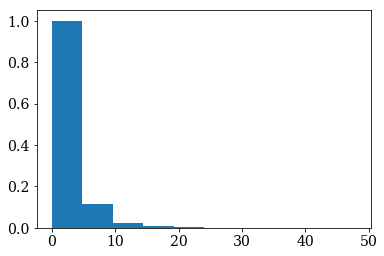

Cumulative degree distribution plot (P(deg>k), k=0,1,…) for Saito Graph


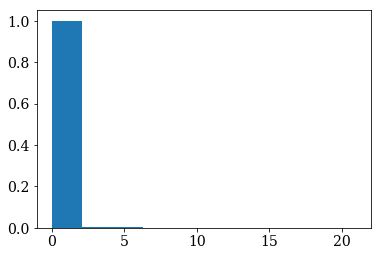

Cumulative degree distribution plot (P(deg>k), k=0,1,…) for Star Graph


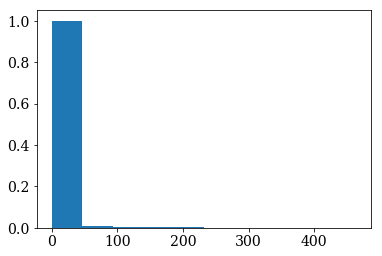

Cumulative degree distribution plot (P(deg>k), k=0,1,…) for Newman Graph


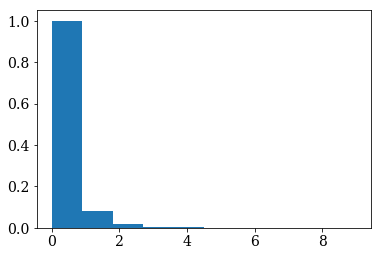

Cumulative degree distribution plot (P(deg>k), k=0,1,…) for Serpent Graph


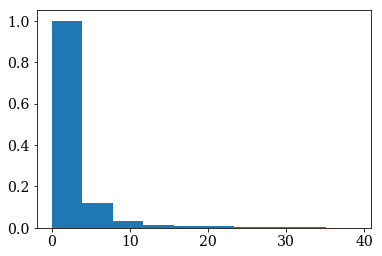

In [262]:
def plot_degree_dist(G, graph_type):
    degrees = [G.out_degree(n) for n in G.nodes()]
#     plt.xlim(0,250)
    plt.hist(degrees, cumulative=-1, density=True)
    print('Cumulative degree distribution plot (P(deg>k), k=0,1,…) for', graph_type, 'Graph')
#     plt.title('Cumulative degree distribution plot (P(deg>k), k=0,1,…) for graph_type graph')
    plt.show()

plot_degree_dist(G_ours, 'Our')
plot_degree_dist(G_saito, 'Saito')
plot_degree_dist(G_star, 'Star')
plot_degree_dist(G_newman, 'Newman')
plot_degree_dist(G_serpent, 'Serpent')

## 8. Mean length of shortest-path from i to j (for any i and j)


In [39]:
def avg_sh_path(G, graph_type):
    print('- Average shortest path for strongly connected components of', graph_type)
    for C in nx.strongly_connected_components(G):
        C = G.subgraph(C)
        if len(C)>1: # skip one nodes
            print('Strongly connected component with average shortest path:', nx.average_shortest_path_length(C))
    return('Done')

avg_sh_path(G_ours, 'Ours')
avg_sh_path(G_saito, 'Saito')
avg_sh_path(G_star, 'Star')
avg_sh_path(G_serpent, 'Serpent')
avg_sh_path(G_newman, 'Newman')


- Average shortest path for strongly connected components of Ours
Strongly connected component with average shortest path: 1.0
- Average shortest path for strongly connected components of Saito
- Average shortest path for strongly connected components of Star
Strongly connected component with average shortest path: 1.0
- Average shortest path for strongly connected components of Serpent
Strongly connected component with average shortest path: 2.5
Strongly connected component with average shortest path: 15.191586538461538
Strongly connected component with average shortest path: 2.5
Strongly connected component with average shortest path: 1.0
- Average shortest path for strongly connected components of Newman
Strongly connected component with average shortest path: 1.0


'Done'

In [239]:
# G = nx.Graph([(1, 2), (3, 4)])
# for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
#     print(C.nodes())
#     print(nx.average_shortest_path_length(C))

## 9. Is there a clustering coefficient for directed graphs

- Weakly connected components are those that are connected when you consider the undirected version of the graph (replace every directed edge with an undirected one). 
- Strongly connected components are those components where every pair of nodes is reachable from each other (has a path).

In [240]:
def avg_sh_path(G, graph_type):
    print('- Average shortest path for strongly connected components of', graph_type)
    for C in nx.strongly_connected_components(G):
        C = G.subgraph(C)
        if len(C)>1: # skip one nodes
            print('Strongly connected component, with average clustering coefficient:', nx.average_clustering(C))
    return('Done')

avg_sh_path(G_ours, 'Ours')
avg_sh_path(G_saito, 'Saito')
avg_sh_path(G_star, 'Star')
avg_sh_path(G_serpent, 'Serpent')
avg_sh_path(G_newman, 'Newman')

- Average shortest path for strongly connected components of Ours
Strongly connected component, with average clustering coefficient: 0.0
Strongly connected component, with average clustering coefficient: 0.0
Strongly connected component, with average clustering coefficient: 0.0034724259028071315
Strongly connected component, with average clustering coefficient: 0.5
Strongly connected component, with average clustering coefficient: 0.0
Strongly connected component, with average clustering coefficient: 0.0
- Average shortest path for strongly connected components of Saito
- Average shortest path for strongly connected components of Newman
Strongly connected component, with average clustering coefficient: 0.0
- Average shortest path for strongly connected components of Star
Strongly connected component, with average clustering coefficient: 0.0
Strongly connected component, with average clustering coefficient: 0.0
Strongly connected component, with average clustering coefficient: 0.0
Stron

'Done'

## Compare [a.] Our graph VS [b.] Saito. x-axis is the threshold sigma>t. And y-axis the percentage of nodes in our graph that have >t threshold over the Saito nodes with >t threshold (we should see for large t that the percentage is higher...)


In [241]:
our_plot = dict()
for thr in range(0, 11):
    thr = thr/10
    print(thr)
    total_edges = 0 
    edges = 0 
    for i in k:
        for j in k[i]:
            if k[i][j]==thr and s[i][j]>=thr: 
                edges+=1
            total_edges+=1
    our_plot[thr] = edges/total_edges
    

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [242]:
our_plot

{0.0: 0.0,
 0.1: 0.003768646951059932,
 0.2: 0.011148913896885632,
 0.3: 0.0,
 0.4: 0.0002093692750588851,
 0.5: 0.027532059670243393,
 0.6: 0.0,
 0.7: 0.0,
 0.8: 5.234231876472128e-05,
 0.9: 0.0,
 1.0: 0.055901596440722325}

<BarContainer object of 11 artists>

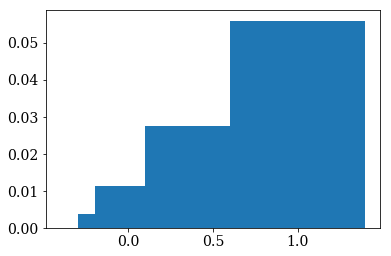

In [243]:
labels, values = zip(*our_plot.items())
plt.bar(labels, values)

## Also, we will need a plot to show the role of trace size: plot the metrics 2., 3., 5., 6, 8, 9, as a function of the trace length - for T=1,000, 10,000, 50,000, 100,000, 200,000, 500,000, 1M, 1.5M etc…

In [244]:
# max(nx.weakly_connected_components(G_ours), key=len)

In [245]:
# for C in nx.weakly_connected_components(G_ours):
#     print(nx.shortest_path_length(C))

In [246]:
# max_scc = max(nx.strongly_connected_components(G_ours), key=len)
# print('Length of maximum strongly connected component in our graph', len(max_scc))
# max_scc = max(nx.strongly_connected_components(G_saito), key=len)
# print('Length of maximum strongly connected component in Saitos graph', len(max_scc))
# max_scc = max(nx.strongly_connected_components(G_star), key=len)
# print('Length of maximum strongly connected component in Star graph', len(max_scc))
# max_scc = max(nx.strongly_connected_components(G_serpent), key=len)
# print('Length of maximum strongly connected component in Serpent graph', len(max_scc))

In [230]:
# print('Max strongly connected components', max(nx.strongly_connected_components(G_ours), key=len))
# print('Max strongly connected components', max(nx.strongly_connected_components(G_star), key=len))
# print('Max strongly connected components', max(nx.strongly_connected_components(G_saito), key=len))

In [231]:
# print('Strongly connected components in our graph')
# [print('our') for c in sorted(nx.strongly_connected_components(G_ours), key=len, reverse=True) if len(c)>3108]

# print('Strongly connected components in Star graph')
# [print('star') for c in sorted(nx.strongly_connected_components(G_star), key=len, reverse=True) if len(c)>6]

# print('Strongly connected components in Saito graph')
# [print('saito') for c in sorted(nx.strongly_connected_components(G_saito), key=len, reverse=True) if len(c)>9]

In [1]:
tweet = 956219412377407488
print('- Episode:', E[tweet])

# pos = nx.spring_layout(G_ours)
pos = 0 
plot1 = plt.figure(1)
plot_tweetgraph(tweet, E, S, Q, k, pos, 'ours')
plot2 = plt.figure(2)
plot_tweetgraph(tweet, E, S, Q, k, pos, 'star')
plot2 = plt.figure(3)
plot_tweetgraph(tweet, E, S, Q, k, pos, 'saito')
plt.show()
plot_tweetgraph(tweet, E, S, Q_newman, k, pos, 'newman')
plt.show()
plot_tweetgraph(tweet, E, S, Q, k, pos, 'serpent')
plt.show()

NameError: name 'E' is not defined

In [ ]:
df[]

In [46]:
df = pd.DataFrame({'name': ['Raphael', 'Donatello'],
                   'mask': ['red', 'purple'],
                   'weapon': ['sai', 'bo staff']})
df.to_csv (r'./export_dataframe.csv', index = False, header=True)


In [256]:
# # Get the list of the degrees
# degree_sequence = list(G_ours.out_degree())

# nb_nodes = len(G_ours.nodes())
# nb_arr = len(G_ours.edges())

# avg_degree = np.mean(np.array(degree_sequence)[:,1])
# # med_degree = np.median(np.array(degree_sequence)[:,1])

# max_degree = max(np.array(degree_sequence)[:,1])
# min_degree = np.min(np.array(degree_sequence)[:,1])

# # esp_degree = (n-1)*p

# print("Number of nodes : " + str(nb_nodes))
# print("Number of edges : " + str(nb_arr))

# print("Maximum degree : " + str(max_degree))
# print("Minimum degree : " + str(min_degree))

# print("Average degree : " + str(avg_degree))
# # print("Expected degree : " + str(esp_degree))
# # print("Median degree : " + str(med_degree))